<a href="https://colab.research.google.com/github/avilaJorge/CSE253_FinalProject/blob/master/DeepFakeDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!rm -R ./Logistic_Regression/*

In [0]:
!cp *.py /content/drive/My\ Drive/CSE\ 253/PA5/PyFiles
!cp *.ipynb /content/drive/My\ Drive/CSE\ 253/PA5/PyFiles

In [0]:
# !wget https://storage.googleapis.com/img-hosting-bucket/Faces_HQ.hdf5

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Mar 11 09:03:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%run DeepFake_Dataloader.py
%run utils.py

In [0]:
# imports pytorch
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Numpy, Matplotlib, and PIL
import numpy as np
import matplotlib.pyplot as plt

# general imports
import pprint

# My imports
from DeepFake_Dataloader import get_dataloaders
from models import LinearRegression, save_model, SVM
from utils import RunningAverage
from train import train, evaluate

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
trn_dl, val_dl, tst_dl = get_dataloaders(dataset=DeepFakeHDF5Dataset())

In [0]:
s_epoch      = 1
num_epochs   = 300
lr_rate      = 1e-2
load_model   = False
model_name   = 'LogisticRegressionModel'
path         = '/content/Logistic_Regression'

lr_model = LinearRegression(725).to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(lr_model.parameters(), lr=lr_rate, weight_decay=1e-3, momentum=0.9)

if load_model:
    lr_model.load_state_dict(torch.load(''))

In [9]:

train_losses, valid_losses = train(lr_model, 
                                   optimizer, 
                                   criterion, 
                                   trn_dl, 
                                   val_dl,
                                   model_name,
                                   path,
                                   predicter=torch.nn.Sigmoid())

Epoch:  1
Training loss: 0.0909


Training Loss:  0.0338
Training accuracy: 99.2625%


Validation Loss:  0.027
Validation accuracy: 99.4375%
"Best Loss": 0.026981634841788383

Validation Loss has gone up 0 times.



Epoch:  2
Training loss: 0.0258


Training Loss:  0.017
Training accuracy: 99.6583%


Validation Loss:  0.0149
Validation accuracy: 99.8250%
"Best Loss": 0.014902554740685792

Validation Loss has gone up 0 times.



Epoch:  3
Training loss: 0.014


Training Loss:  0.0101
Training accuracy: 99.8083%


Validation Loss:  0.0098
Validation accuracy: 99.8875%
"Best Loss": 0.009778855309363397

Validation Loss has gone up 0 times.



Epoch:  4
Training loss: 0.009


Training Loss:  0.008
Training accuracy: 99.8792%


Validation Loss:  0.0085
Validation accuracy: 99.9000%
"Best Loss": 0.00853749269634367

Validation Loss has gone up 0 times.



Epoch:  5
Training loss: 0.0068


Training Loss:  0.0071
Training accuracy: 99.8292%


Validation Loss:  0.007
Validation accuracy: 99.8875%
"Best Loss": 0.006988705435235585

Validation Loss has gone up 0 times.



Epoch:  6
Training loss: 0.0056


Training Loss:  0.0048
Training accuracy: 99.9000%


Validation Loss:  0.0052
Validation accuracy: 99.9125%
"Best Loss": 0.00518380723605376

Validation Loss has gone up 0 times.



Epoch:  7
Training loss: 0.0051


Training Loss:  0.0043
Training accuracy: 99.9292%


Validation Loss:  0.0047
Validation accuracy: 99.9250%
"Best Loss": 0.004707567619218952

Validation Loss has gone up 0 times.



Epoch:  8
Training loss: 0.0044


Training Loss:  0.0038
Training accuracy: 99.9208%


Validation Loss:  0.0044
Validation accuracy: 99.9125%
"Best Loss": 0.004360992095566222

Validation Loss has gone up 0 times.



Epoch:  9
Training loss: 0.0039


Training Loss:  0.0059
Training accuracy: 99.9167%


Validation Loss:  0.0064
Validation accuracy: 99.9125%
Validation Loss has gone up 1 times.



Epoch:  10
Training loss: 0.0037


Training Loss:  0.0033
Training accuracy: 99.9417%


Validation Loss:  0.0041
Validation accuracy: 99.9375%
"Best Loss": 0.004065467426294668

Validation Loss has gone up 0 times.



Epoch:  11
Training loss: 0.0035


Training Loss:  0.0032
Training accuracy: 99.9458%


Validation Loss:  0.0039
Validation accuracy: 99.9375%
"Best Loss": 0.003885717287341813

Validation Loss has gone up 0 times.



Epoch:  12
Training loss: 0.0033


Training Loss:  0.003
Training accuracy: 99.9500%


Validation Loss:  0.0037
Validation accuracy: 99.9250%
"Best Loss": 0.003672694983256478

Validation Loss has gone up 0 times.



Epoch:  13
Training loss: 0.0033


Training Loss:  0.0029
Training accuracy: 99.9458%


Validation Loss:  0.0036
Validation accuracy: 99.9250%
"Best Loss": 0.0036129790676077676

Validation Loss has gone up 0 times.



Epoch:  14
Training loss: 0.003


Training Loss:  0.003
Training accuracy: 99.9500%


Validation Loss:  0.0037
Validation accuracy: 99.9375%
Validation Loss has gone up 1 times.



Epoch:  15
Training loss: 0.003


Training Loss:  0.0027
Training accuracy: 99.9458%


Validation Loss:  0.0034
Validation accuracy: 99.9250%
"Best Loss": 0.003393291121548308

Validation Loss has gone up 0 times.



Epoch:  16
Training loss: 0.0028


Training Loss:  0.0028
Training accuracy: 99.9583%


Validation Loss:  0.0035
Validation accuracy: 99.9250%
Validation Loss has gone up 1 times.



Epoch:  17
Training loss: 0.0028


Training Loss:  0.0026
Training accuracy: 99.9625%


Validation Loss:  0.0033
Validation accuracy: 99.9250%
"Best Loss": 0.003325480356117681

Validation Loss has gone up 0 times.



Epoch:  18
Training loss: 0.0028


Training Loss:  0.0027
Training accuracy: 99.9583%


Validation Loss:  0.0034
Validation accuracy: 99.9250%
Validation Loss has gone up 1 times.



Epoch:  19
Training loss: 0.0027


Training Loss:  0.0026
Training accuracy: 99.9583%


Validation Loss:  0.0033
Validation accuracy: 99.9250%
"Best Loss": 0.0032608196848914737

Validation Loss has gone up 0 times.



Epoch:  20
Training loss: 0.0028


Training Loss:  0.0026
Training accuracy: 99.9667%


Validation Loss:  0.0033
Validation accuracy: 99.9250%
Validation Loss has gone up 1 times.



Epoch:  21
Training loss: 0.0028


Training Loss:  0.0028
Training accuracy: 99.9750%


Validation Loss:  0.0033
Validation accuracy: 99.9500%
Validation Loss has gone up 2 times.



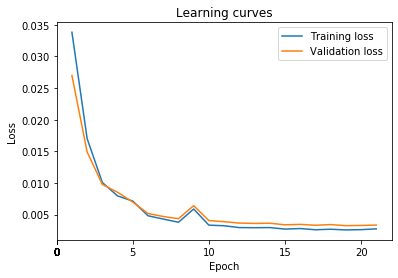

In [10]:
epochs = range(1, len(train_losses) + 1)
epoch_ticks = [i if i % 5 == 0 else 0 for i in epochs]
    
# plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, valid_losses, label='Validation loss')
plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [0]:
trn_dl, val_dl, tst_dl = get_dataloaders(dataset=DeepFakeHDF5Dataset_SVM())

In [0]:
s_epoch      = 1
num_epochs   = 300
lr_rate      = 1e-3
load_model   = False
model_name   = 'SVMModel'
path         = '/content/SVM_Model'

svm_model = SVM(725).to(device)
criterion = torch.nn.HingeEmbeddingLoss()
optimizer = torch.optim.SGD(svm_model.parameters(), lr=lr_rate, weight_decay=1e-3, momentum=0.9)

if load_model:
    svm_model.load_state_dict(torch.load(''))

In [15]:

train_losses, valid_losses = train(svm_model, 
                                   optimizer, 
                                   criterion, 
                                   trn_dl, 
                                   val_dl,
                                   model_name,
                                   path,
                                   predicter=torch.nn.Sigmoid())

Epoch:  1
Training loss: 0.5103


Training Loss:  0.5067
Training accuracy: 0.0000%


Validation Loss:  0.5122
Validation accuracy: 0.0000%
"Best Loss": 0.5121561029837244

Validation Loss has gone up 0 times.



Epoch:  2
Training loss: 0.5198


Training Loss:  0.5019
Training accuracy: 0.5000%


Validation Loss:  0.5039
Validation accuracy: 0.5875%
"Best Loss": 0.5038876779495726

Validation Loss has gone up 0 times.



Epoch:  3
Training loss: 0.5048


Training Loss:  0.5167
Training accuracy: 0.0000%


Validation Loss:  0.5187
Validation accuracy: 0.0000%
Validation Loss has gone up 1 times.



Epoch:  4
Training loss: 0.5372


Training Loss:  0.5101
Training accuracy: 0.0000%


Validation Loss:  0.5133
Validation accuracy: 0.0000%
Validation Loss has gone up 0 times.



Epoch:  5
Training loss: 0.4932


Training Loss:  0.5249
Training accuracy: 0.0000%


Validation Loss:  0.5307
Validation accuracy: 0.0000%
Validation Loss has gone up 1 times.



Epoch:  6
Training loss: 0.5322


Training Loss:  0.515
Training accuracy: 0.0000%


Validation Loss:  0.517
Validation accuracy: 0.0000%
Validation Loss has gone up 0 times.



Epoch:  7
Training loss: 0.5188


Training Loss:  0.5024
Training accuracy: 0.0250%


Validation Loss:  0.5039
Validation accuracy: 0.0125%
"Best Loss": 0.5038763294144281

Validation Loss has gone up 0 times.



Epoch:  8
Training loss: 0.5093


Training Loss:  0.5058
Training accuracy: 0.0000%


Validation Loss:  0.5109
Validation accuracy: 0.0000%
Validation Loss has gone up 1 times.



Epoch:  9
Training loss: 0.5108


Training Loss:  0.5005
Training accuracy: 6.7208%


Validation Loss:  0.5019
Validation accuracy: 6.7125%
"Best Loss": 0.5018653604719373

Validation Loss has gone up 0 times.



Epoch:  10
Training loss: 0.5082


Training Loss:  0.4994
Training accuracy: 25.3625%


Validation Loss:  0.5005
Validation accuracy: 24.8500%
"Best Loss": 0.5004827455868797

Validation Loss has gone up 0 times.



Epoch:  11
Training loss: 0.5056


Training Loss:  0.4986
Training accuracy: 47.1167%


Validation Loss:  0.4991
Validation accuracy: 46.8875%
"Best Loss": 0.49908166745352367

Validation Loss has gone up 0 times.



Epoch:  12
Training loss: 0.5041


Training Loss:  0.5021
Training accuracy: 0.0000%


Validation Loss:  0.5038
Validation accuracy: 0.0000%
Validation Loss has gone up 1 times.



Epoch:  13
Training loss: 0.5064


Training Loss:  0.504
Training accuracy: 0.0000%


Validation Loss:  0.5045
Validation accuracy: 0.0000%
Validation Loss has gone up 2 times.



In [0]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pickle

# num = 5
# LR = 0
# SVM = 0
# SVM_r = 0
# SVM_p = 0


# for z in range(num):
#     # read python dict back from the file
#     data = None
#     lbls = None
#     og_d = None
#     with h5py.File(fhq_hdf5_pt, 'r') as hdf5_file: 
#         data = hdf5_file['fft_data'][:]
#         lbls = hdf5_file['lbl_data'][:]
#         og_d = hdf5_file['orgn_data'][:]

#     X = data 
#     y = lbls 


#     try:

#         from sklearn.model_selection import train_test_split
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#         from sklearn.svm import SVC
#         svclassifier = SVC(kernel='linear')
#         svclassifier.fit(X_train, y_train)
#         #print('Accuracy on test set: {:.3f}'.format(svclassifier.score(X_test, y_test)))
               
#         from sklearn.svm import SVC
#         svclassifier_r = SVC(C=3.1, kernel='rbf', gamma=0.00002)
#         svclassifier_r.fit(X_train, y_train)
#         #print('Accuracy on test set: {:.3f}'.format(svclassifier_r.score(X_test, y_test)))
                
#         from sklearn.svm import SVC
#         svclassifier_p = SVC(kernel='poly')
#         svclassifier_p.fit(X_train, y_train)
#         #print('Accuracy on test set: {:.3f}'.format(svclassifier_p.score(X_test, y_test)))
        
#         from sklearn.linear_model import LogisticRegression
#         logreg = LogisticRegression(solver='liblinear', max_iter=1000)
#         logreg.fit(X_train, y_train)
#         #print('Accuracy on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

        
#         SVM+=svclassifier.score(X_test, y_test)
#         SVM_r+=svclassifier_r.score(X_test, y_test)
#         SVM_p+=svclassifier_p.score(X_test, y_test)
#         LR+=logreg.score(X_test, y_test)

 
#     except:
#         num-=1
#         print(num)
    
# print("Average SVM: "+str(SVM/num))
# print("Average SVM_r: "+str(SVM_r/num))
# print("Average SVM_p: "+str(SVM_p/num))
# print("Average LR: "+str(LR/num))